In [185]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import convolve2d

# IRIS SEGMENTATION

In [186]:
class IrisSegmenter:

    def __init__(self, image_path):

        self.image = cv2.imread(image_path)
        if self.image is None:
            raise ValueError("Cannot load image. Check the path.")
        
        self.gray = cv2.cvtColor(self.image, cv2.COLOR_BGR2GRAY)
        self.pupil_center = None
        self.pupil_radius = None
        self.iris_radius = None
        self.iris_center = None
        self.unwrapped_iris = None
        
    def plot_image(self, title, image, cmap='gray'):
        plt.figure(figsize=(6, 6))
        plt.title(title)
        plt.imshow(image, cmap=cmap)
        plt.axis('off')
        plt.show()
        
    def binarize(self, factor):

        h, w = self.gray.shape
        P = np.sum(self.gray) / (h * w)
        threshold = P / factor
        binary = (self.gray > threshold).astype(np.uint8) * 255
        self.plot_image("Binarized Image", binary)
        return binary
    
    def clean_objects(self, binary_image):

        inverted = cv2.bitwise_not(binary_image)
        contours, _ = cv2.findContours(inverted, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        if not contours:
            print("No contours found")
            return binary_image
        
        largest_contour = max(contours, key=cv2.contourArea)
        largest_object = np.zeros_like(inverted)
        cv2.drawContours(largest_object, [largest_contour], -1, 255, -1)
        cleaned = cv2.bitwise_not(largest_object)
        self.plot_image("Cleaned Objects", cleaned)
        return cleaned
    
    def clean_pupil(self, Xp):

        binary_pupil = self.binarize(Xp)
        kernel_small = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
        kernel_large = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
        cleaned = self.clean_objects(binary_pupil)

        cleaned = cv2.morphologyEx(cleaned, cv2.MORPH_CLOSE, kernel_large, iterations=2)
        cleaned = cv2.erode(cleaned, kernel_small, iterations=2)
        cleaned = cv2.dilate(cleaned, kernel_small, iterations=2)
        cleaned = cv2.medianBlur(cleaned, 5)
        cleaned = cv2.morphologyEx(cleaned, cv2.MORPH_OPEN, kernel_large, iterations=2)
        self.plot_image("Cleaned Pupil", cleaned)
        return cleaned

    def detect_pupil(self, Xp, diff):
        
        clean = self.clean_pupil(Xp)

        h_proj = np.sum(clean, axis=1)
        v_proj = np.sum(clean, axis=0)

        self.show_projections(clean, h_proj, v_proj, "Pupil Projections")
        
        y_candidates = np.where(h_proj == np.min(h_proj))[0]
        x_candidates = np.where(v_proj == np.min(v_proj))[0]
        
        y_center = int(np.median(y_candidates)) if len(y_candidates) > 0 else h_proj.shape[0] // 2
        x_center = int(np.median(x_candidates)) if len(x_candidates) > 0 else v_proj.shape[0] // 2
        self.pupil_center = (x_center, y_center)
        
        h_diff = np.abs(np.diff(h_proj.astype(np.int64)))
        v_diff = np.abs(np.diff(v_proj.astype(np.int64)))

        h_edges = np.where(h_diff > np.max(h_diff) * diff)[0]
        v_edges = np.where(v_diff > np.max(v_diff) * diff)[0]

        r_y = (h_edges[-1] - h_edges[0]) // 2 if len(h_edges) >= 2 else 0
        r_x = (v_edges[-1] - v_edges[0]) // 2 if len(v_edges) >= 2 else 0
        self.pupil_radius = (r_x + r_y) // 2
    
    def clean_iris(self, Xi):
        
        binary_iris = self.binarize(Xi)
        kernel_large = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (9, 9))

        cleaned = self.clean_objects(binary_iris)

        cleaned = cv2.morphologyEx(cleaned, cv2.MORPH_CLOSE, kernel_large, iterations=2)
        cleaned = cv2.morphologyEx(cleaned, cv2.MORPH_OPEN, kernel_large, iterations=2)
        self.plot_image("Cleaned Iris", cleaned)
        return cleaned
    
    def detect_iris(self, Xi, diff):

        clean = self.clean_iris(Xi)

        h_proj = np.sum(clean, axis=1)
        v_proj = np.sum(clean, axis=0)

        self.show_projections(clean, h_proj, v_proj, "Iris Projections")

        d45_proj = np.sum(np.rot90(clean, k=1), axis=1)
        d135_proj = np.sum(np.rot90(clean, k=3), axis=1)

        y_indices = np.arange(len(h_proj))
        x_indices = np.arange(len(v_proj))

        y_center = int(np.sum(y_indices * h_proj) / np.sum(h_proj)) if np.sum(h_proj) > 0 else clean.shape[0] // 2
        x_center = int(np.sum(x_indices * v_proj) / np.sum(v_proj)) if np.sum(v_proj) > 0 else clean.shape[1] // 2

        self.iris_center = (x_center, y_center)
        
        h_diff = np.abs(np.diff(h_proj.astype(np.int64)))
        v_diff = np.abs(np.diff(v_proj.astype(np.int64)))
        d45_diff = np.abs(np.diff(d45_proj.astype(np.int64)))
        d135_diff = np.abs(np.diff(d135_proj.astype(np.int64)))

        h_edges = np.where(h_diff > np.max(h_diff) * diff)[0]
        v_edges = np.where(v_diff > np.max(v_diff) * diff)[0]
        d45_edges = np.where(d45_diff > np.max(d45_diff) * diff)[0]
        d135_edges = np.where(d135_diff > np.max(d135_diff) * diff)[0]

        r_h = (h_edges[-1] - h_edges[0]) // 2 if len(h_edges) >= 2 else 0
        r_v = (v_edges[-1] - v_edges[0]) // 2 if len(v_edges) >= 2 else 0
        r_45 = (d45_edges[-1] - d45_edges[0]) // 2 if len(d45_edges) >= 2 else 0
        r_135 = (d135_edges[-1] - d135_edges[0]) // 2 if len(d135_edges) >= 2 else 0

        r = int(np.mean([r_h, r_v, r_45, r_135]))

        self.iris_radius = r
        self.iris_center = (x_center, y_center)

    
    def draw_contour(self):
        
        output = self.image.copy()
        cv2.circle(output, self.pupil_center, self.pupil_radius, (57, 255, 10), 1)
        cv2.circle(output, self.pupil_center, self.iris_radius, (255, 0, 0), 1)
        self.plot_image("Contours Drawn", output)
        return output
    
    
    def unwrap_iris(self, output_shape=(128, 512)):

        height, width = output_shape
        unwrapped = np.zeros(output_shape, dtype=np.uint8)
        
        cx, cy = self.pupil_center
        
        for y in range(height):
            for x in range(width):
                theta = 2 * np.pi * x / width 
                r = self.pupil_radius + (self.iris_radius - self.pupil_radius) * y / height 

                xi = int(cx + r * np.cos(theta))
                yi = int(cy + r * np.sin(theta))
                
                if 0 <= xi < self.gray.shape[1] and 0 <= yi < self.gray.shape[0]:
                    unwrapped[y, x] = self.gray[yi, xi]
        
        self.plot_image("Unwrapped Iris", unwrapped)
        self.unwrapped_iris = unwrapped
        return unwrapped
    

    def extract_bands(self ):
        
        height, width = self.unwrapped_iris.shape
        band_height = height // 8
        
        bands = []
        masks = []
        masked_bands = []
        
        for i in range(8):
            
            band_start = i * band_height
            band_end = min((i + 1) * band_height, height)
            band = self.unwrapped_iris[band_start:band_end, :]

            mask = np.ones_like(band, dtype=bool)
            
            if i < 4:
                bottom_center = 3 * width // 4
                sector_width = int(width * (30 / 360))
                start_idx = (bottom_center - sector_width // 2) % width
                end_idx = (bottom_center + sector_width // 2) % width
                
                if start_idx < end_idx:
                    mask[:, start_idx:end_idx] = False
                else:
                    mask[:, start_idx:] = False
                    mask[:, :end_idx] = False
                    
            elif i < 6:
                included_angle = 226
                half_included = included_angle / 2
                
                start_angle = (90 - half_included) % 360
                end_angle = (90 + half_included) % 360
                
                start_idx = int(start_angle * width / 360)
                end_idx = int(end_angle * width / 360)

                temp_mask = np.zeros_like(mask)
                
                if start_idx < end_idx:
                    temp_mask[:, start_idx:end_idx] = True
                else:
                    temp_mask[:, start_idx:] = True
                    temp_mask[:, :end_idx] = True
                
                mask = temp_mask
                
            else:
                included_angle = 180
                half_included = included_angle / 2

                start_angle = (90 - half_included) % 360
                end_angle = (90 + half_included) % 360
                
                start_idx = int(start_angle * width / 360)
                end_idx = int(end_angle * width / 360)
                
                temp_mask = np.zeros_like(mask)
                
                if start_idx < end_idx:
                    temp_mask[:, start_idx:end_idx] = True
                else:
                    temp_mask[:, start_idx:] = True
                    temp_mask[:, :end_idx] = True
                
                mask = temp_mask

            
            masked_band = np.where(mask, band, 0)
            masked_bands.append(masked_band)
            
            self.plot_image(f"Band {i+1}", masked_band)
            bands.append(band)
            masks.append(mask)
        
        stack = np.vstack(masked_bands)
        self.plot_image("Stacked Bands", stack)


    def show_projections(self, img, horizontal_projection, vertical_projection, object):

        fig = plt.figure(figsize=(12, 8))

        ax1 = plt.subplot2grid((2, 2), (0, 0))
        ax1.imshow(img, cmap='gray')
        ax1.set_title('Detected object')
        ax1.axis('off')

        ax2 = plt.subplot2grid((2, 2), (0, 1))
        ax2.plot(horizontal_projection[::-1], np.arange(len(horizontal_projection)), color='#ff073a')
        ax2.set_title('Horizontal projection')
        ax2.set_ylabel('Row (y)')
        ax2.set_xlabel('Brightness sum')
        ax2.invert_yaxis()
        ax2.invert_xaxis()
        ax2.grid(True)

        ax3 = plt.subplot2grid((2, 2), (1, 0))
        ax3.plot(np.arange(len(vertical_projection)), vertical_projection, color='#ff073a')
        ax3.set_title('Vertical projection')
        ax3.set_xlabel('Column (x)')
        ax3.set_ylabel('Brightness sum')
        ax3.grid(True)

        ax4 = plt.subplot2grid((2, 2), (1, 1))
        ax4.axis('off')
        ax4.text(0.5, 0.5, f'{object}', ha='center', va='center', fontsize=12)

        plt.tight_layout()
        plt.show()

    
    def process(self, Xi, Xp, diff=0.3):
        
        self.detect_pupil(Xp, diff)
        self.detect_iris(Xi, diff)
        self.draw_contour()
        self.unwrap_iris()
        self.extract_bands()

# IRIS RECOGNITION / COMPARISON / CODING

In [187]:
class IrisRecognizer:
    def __init__(self, unwrapped_iris):
        self.unwrapped_iris = unwrapped_iris
        self.iris_code = None
        self.iris_mask = None


    def set_gabor_parameters(self, frequency):
        self.gabor_frequency = frequency
        self.gabor_sigma = 0.5 * (np.pi * frequency)

        
    def gabor_kernel(self, size):
        x = np.linspace(-size//2, size//2, size)
        y = np.linspace(-size//2, size//2, size)
        X, Y = np.meshgrid(x, y)

        theta = 0 
        X_theta = X * np.cos(theta) + Y * np.sin(theta)

        envelope = np.exp(-0.5 * ((X**2 + Y**2)/(self.gabor_sigma**2)))
        carrier = np.exp(1j * (2 * np.pi * self.gabor_frequency * X_theta))

        return envelope * carrier
    

    def apply_gabor_filters(self, img_band, size):
        gabor = self.gabor_kernel(size)
        real_part = convolve2d(img_band, np.real(gabor), mode='same', boundary='wrap')
        imag_part = convolve2d(img_band, np.imag(gabor), mode='same', boundary='wrap')
        return real_part + 1j * imag_part
    

    def quantize_response(self, response):
        real = np.real(response)
        imag = np.imag(response)
        bit1 = (real >= 0).astype(np.uint8)
        bit2 = (imag >= 0).astype(np.uint8)
        return np.stack([bit1, bit2], axis=-1)


    def create_band_mask(self, width, band_idx):
        mask = np.ones(width, dtype=bool)
        
        if band_idx < 4:
            exclusion_center = 3 * width // 4
            exclusion_width = int(width * 30/360)
            start = (exclusion_center - exclusion_width//2) % width
            end = (exclusion_center + exclusion_width//2) % width
            
            if start < end:
                mask[start:end] = False
            else:
                mask[start:] = False
                mask[:end] = False
                
        elif band_idx < 6:  
            mask.fill(False)
            sector_width = int(width * 226/360)
            start = (width - sector_width) // 2
            end = start + sector_width
            mask[start:end] = True
            
        else:  
            mask.fill(False)
            sector_width = width // 2
            start = (width - sector_width) // 2
            end = start + sector_width
            mask[start:end] = True
            
        return mask


    def process_iris(self, frequency=np.pi, kernel_size=64):
        self.set_gabor_parameters(frequency)
        height, width = self.unwrapped_iris.shape
        band_height = height // 8
        all_codes = []
        all_masks = []

        for band_idx in range(8):
            band = self.unwrapped_iris[band_idx*band_height:(band_idx+1)*band_height, :]
            mask = self.create_band_mask(width, band_idx)
            
            response = self.apply_gabor_filters(band, kernel_size)
            quantized = self.quantize_response(response)
            
            band_code = quantized.reshape(-1, 2)
            band_mask = np.repeat(mask, band_height * 2)
            
            all_codes.append(band_code)
            all_masks.append(band_mask)

        self.iris_code = np.concatenate(all_codes).flatten()
        self.iris_mask = np.concatenate(all_masks)
        
        return self.iris_code, self.iris_mask
    

    def hamming_distance(self, other_recognizer, max_shift=8):
            
        min_distance = 1.0
        
        for shift in range(-max_shift, max_shift+1):
            shifted_code = np.roll(other_recognizer.iris_code, shift*2)
            shifted_mask = np.roll(other_recognizer.iris_mask, shift*2)
            
            combined_mask = self.iris_mask & shifted_mask
            valid_bits = np.sum(combined_mask)
            
            if valid_bits == 0:
                continue
                
            diff = np.logical_xor(self.iris_code, shifted_code)
            masked_diff = diff & combined_mask
            distance = np.sum(masked_diff) / valid_bits
            
            if distance < min_distance:
                min_distance = distance
                
        return min_distance
    

    def visualize_iris_code(self, rows=16, cols=128):
 
        total_bits = len(self.iris_code)
        if rows * cols > total_bits:
            padding = np.zeros(rows*cols - total_bits, dtype=np.uint8)
            visualized_code = np.concatenate([self.iris_code, padding])
        else:
            visualized_code = self.iris_code[:rows*cols]
            
        img = visualized_code.reshape(rows, cols)
        
        plt.figure(figsize=(12, 3))
        plt.title('Iris Code Visualization')
        plt.imshow(img, cmap='gray')
        plt.axis('off')
        plt.show()

# EXPERIMENTS

**Iris detection**

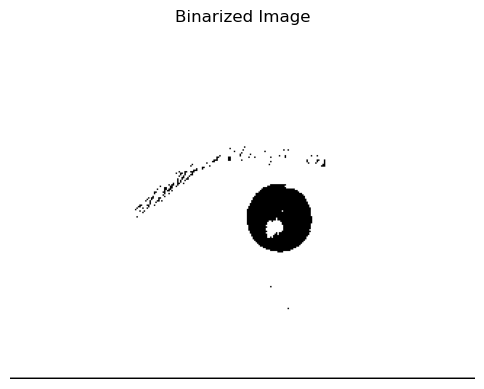

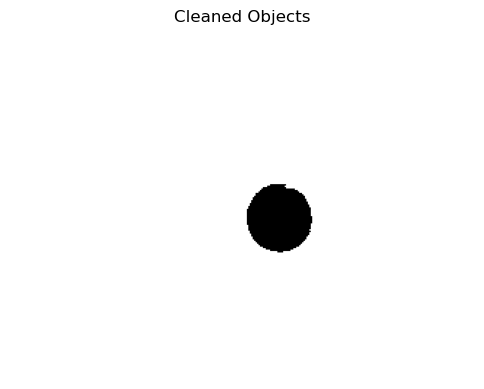

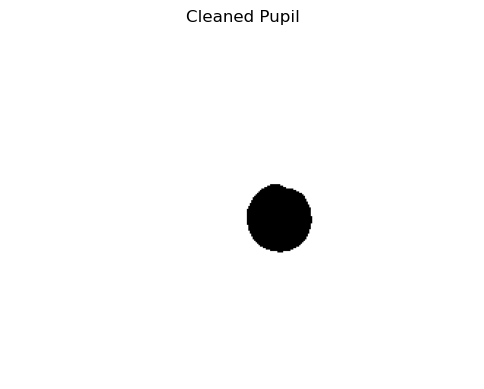

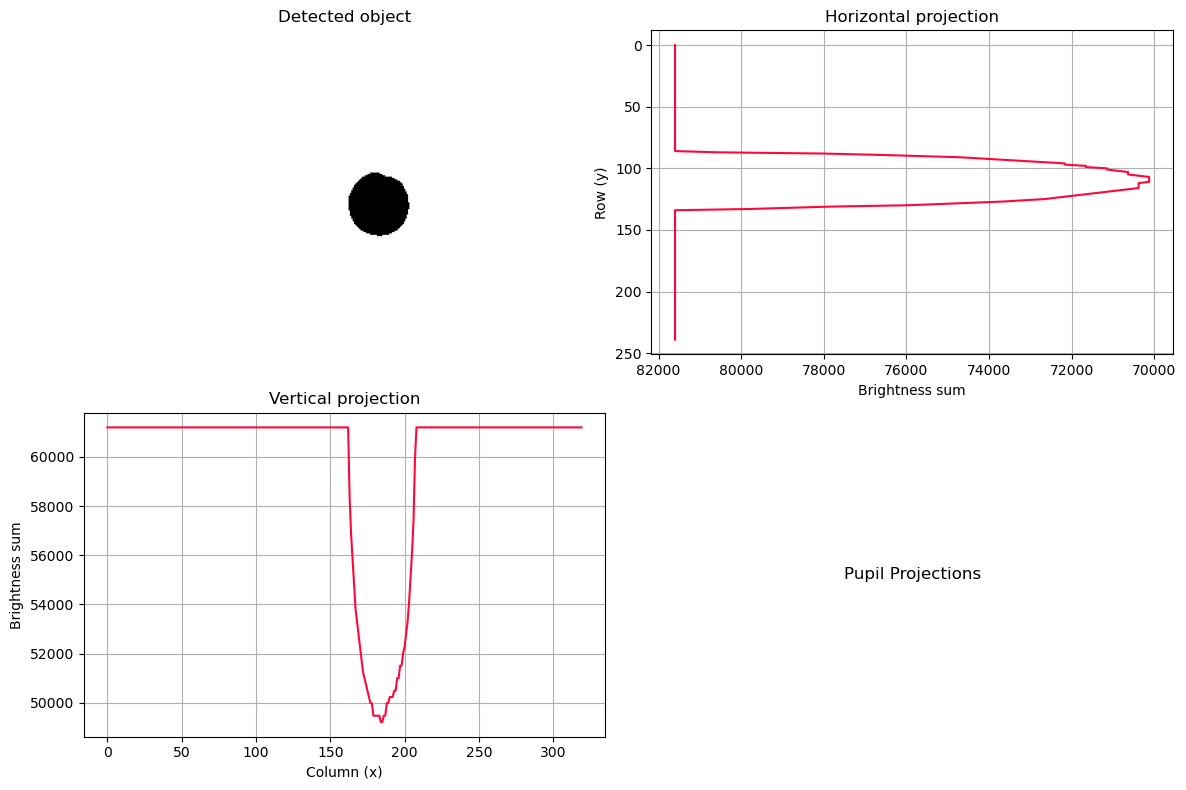

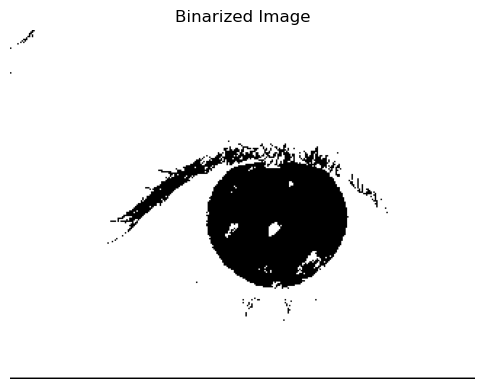

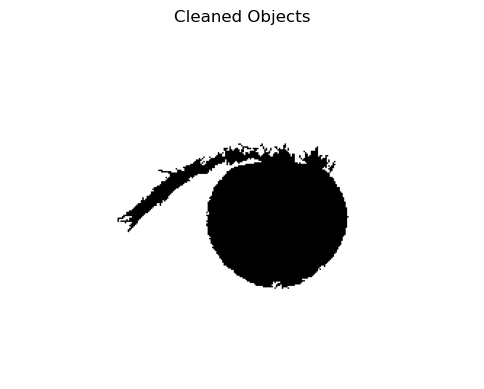

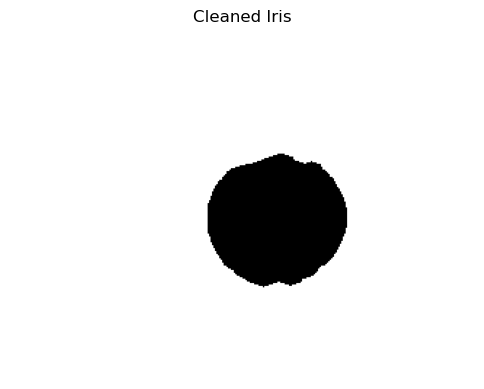

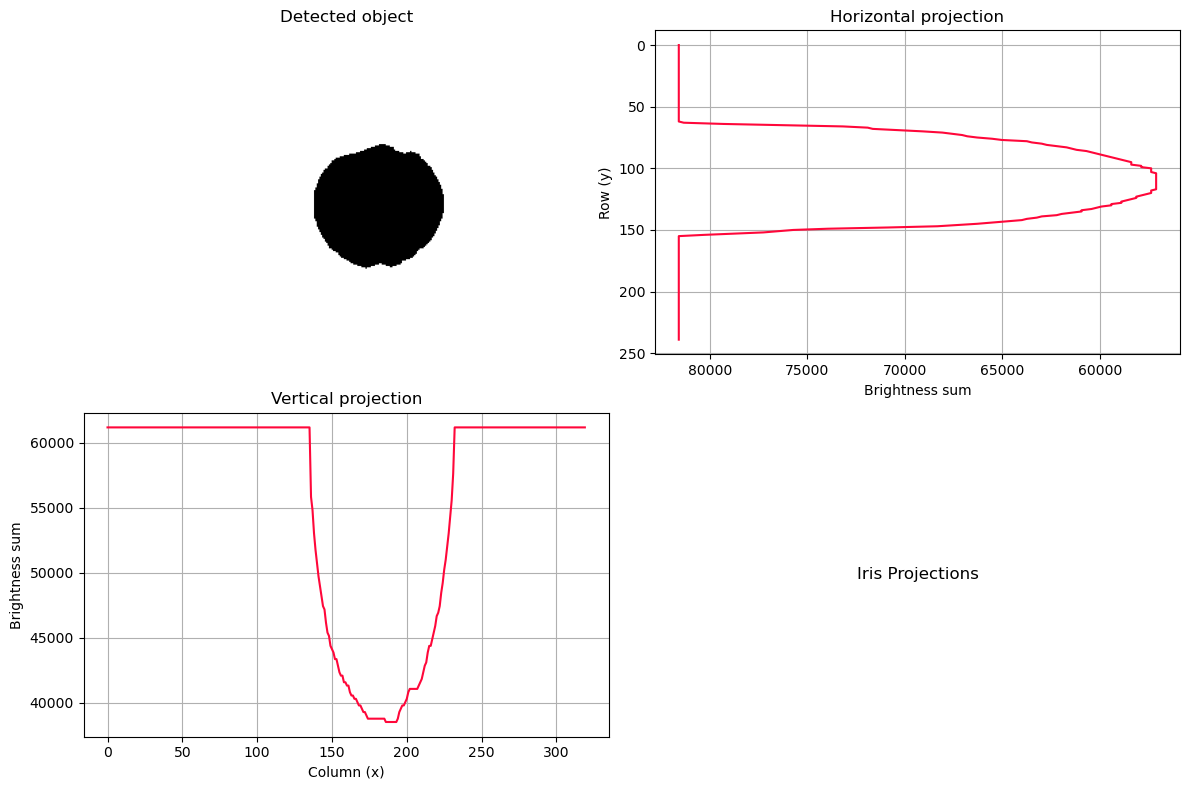

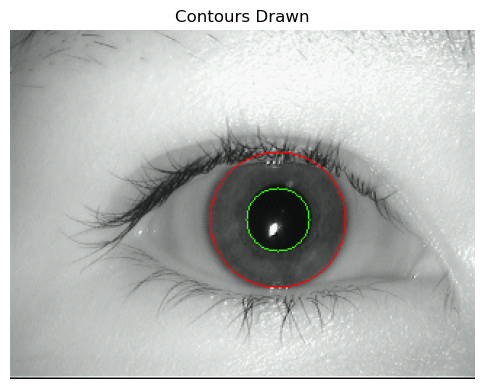

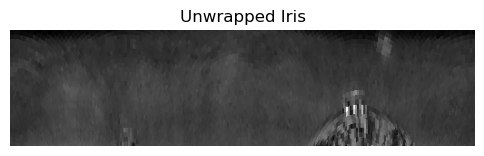

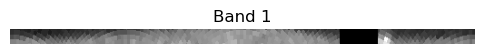

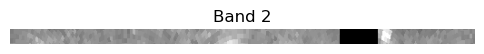

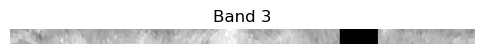

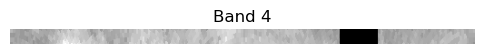

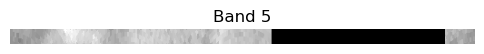

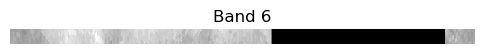

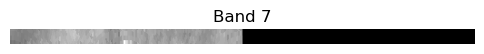

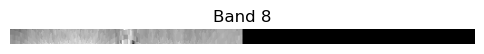

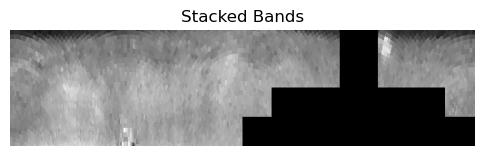

In [188]:
processor = IrisSegmenter("./data/MMU-Iris-Database/1/right/aevar1.bmp")
processor.process(Xi=2.2, Xp=5.0)

**Iris code**

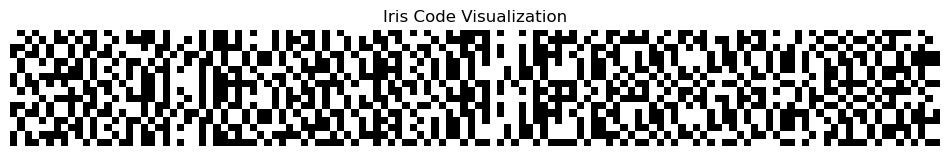

In [189]:
coder = IrisRecognizer(processor.unwrapped_iris)
coder.process_iris(kernel_size=50, frequency=np.pi)
coder.visualize_iris_code()

**Let's compare iris form the same image**

In [190]:
coder.hamming_distance(coder, max_shift=8)

0.0

**Let's add different image of the same iris**

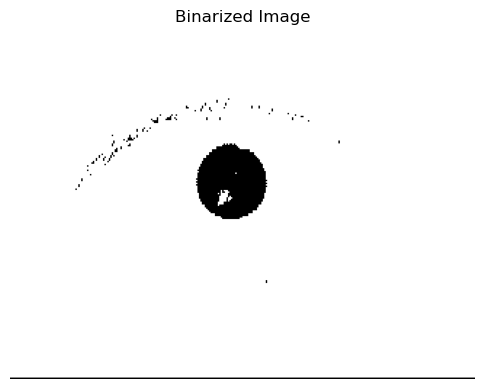

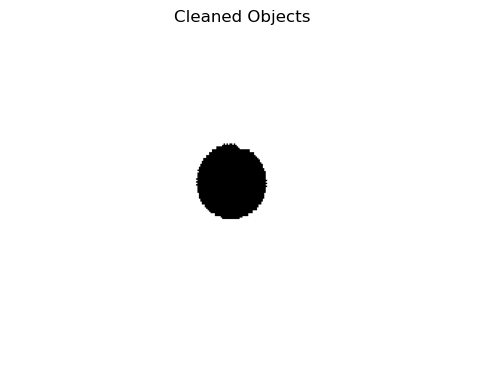

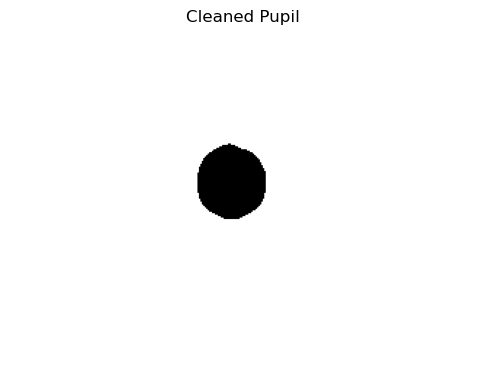

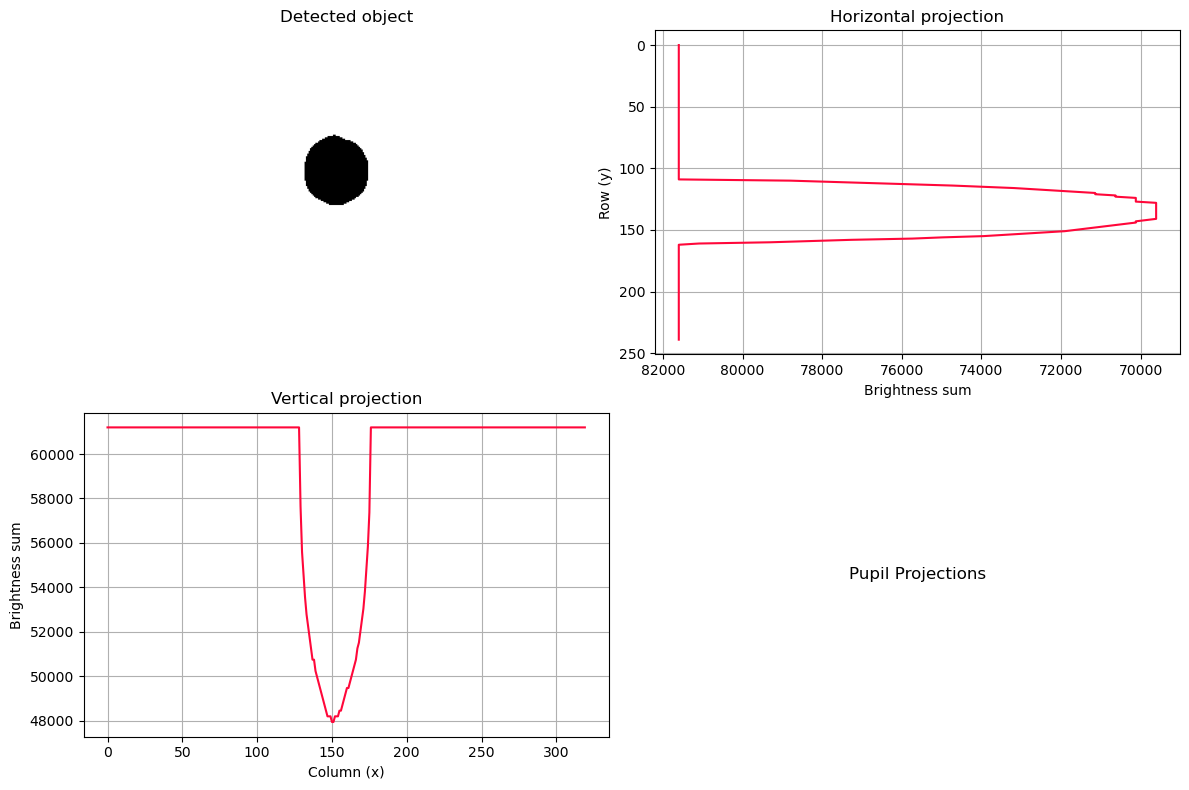

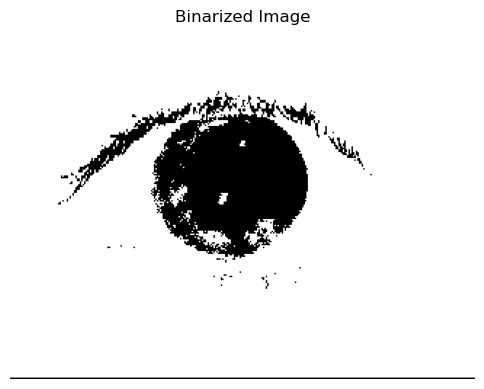

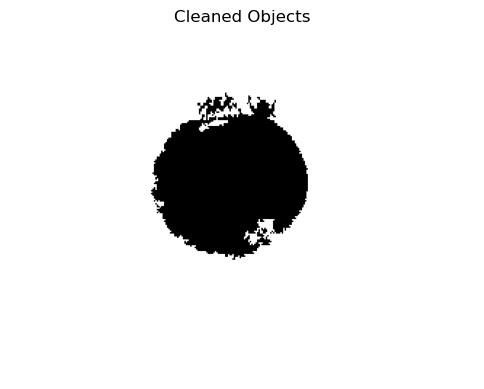

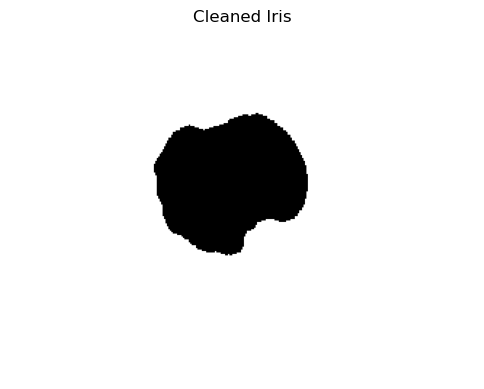

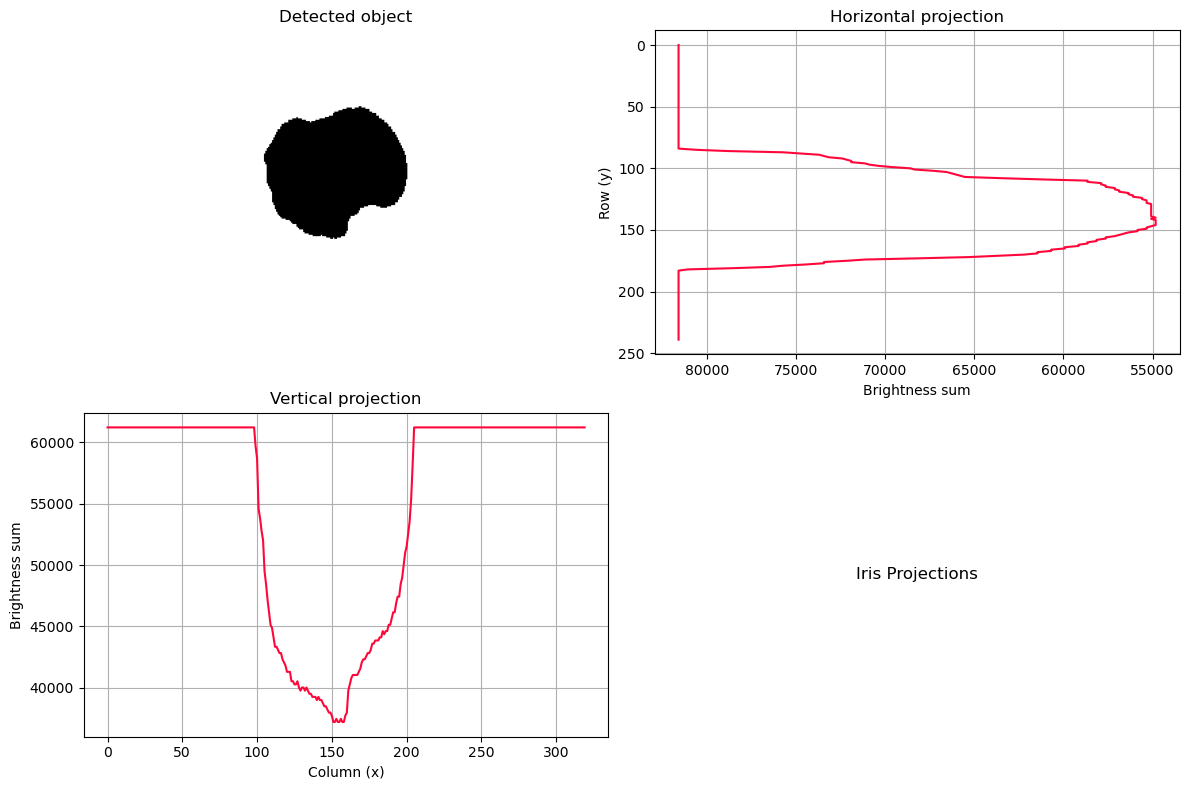

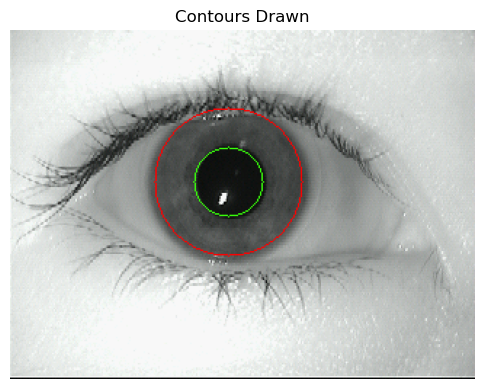

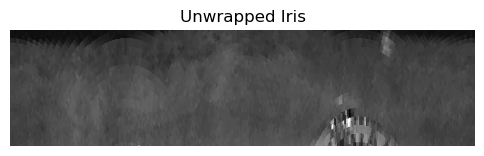

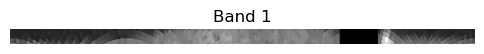

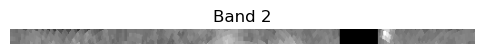

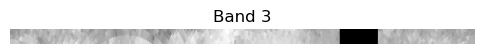

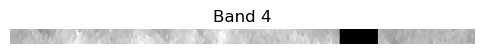

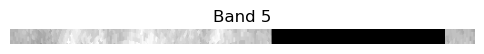

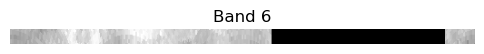

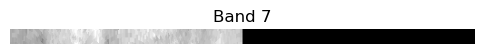

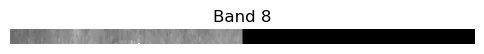

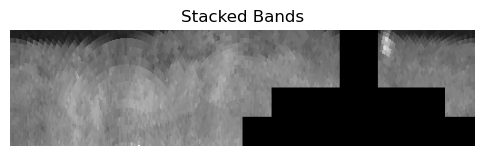

In [191]:
processor2 = IrisSegmenter("./data/MMU-Iris-Database/1/right/aevar2.bmp")
processor2.process(Xi=2.2, Xp=5.0)

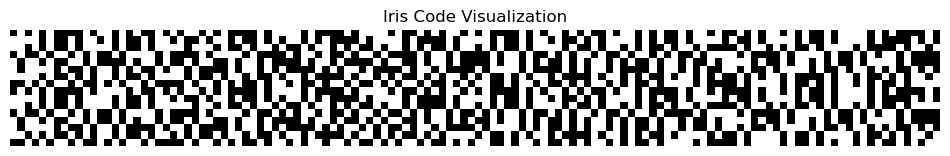

In [192]:
coder2 = IrisRecognizer(processor2.unwrapped_iris)
coder2.process_iris(kernel_size=50, frequency=np.pi)
coder2.visualize_iris_code()

**Comparison**

In [193]:
coder.hamming_distance(coder2, max_shift=8)

0.44902211586070306

**Let's check other eyes**

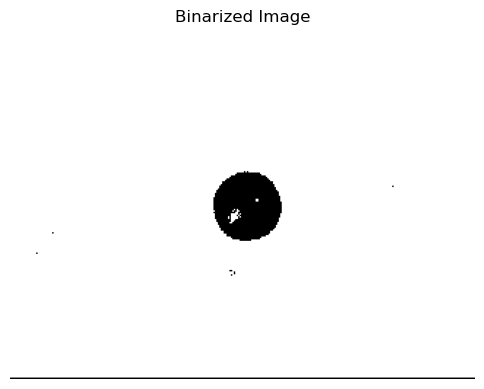

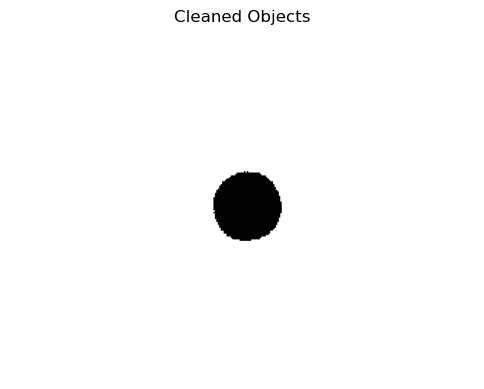

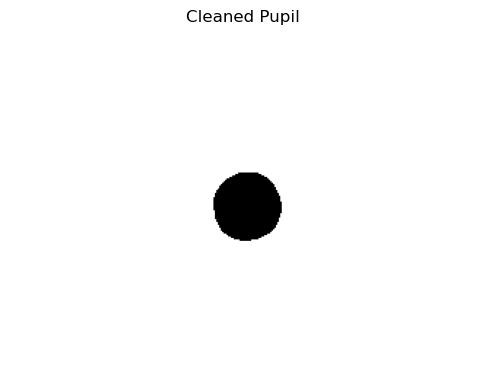

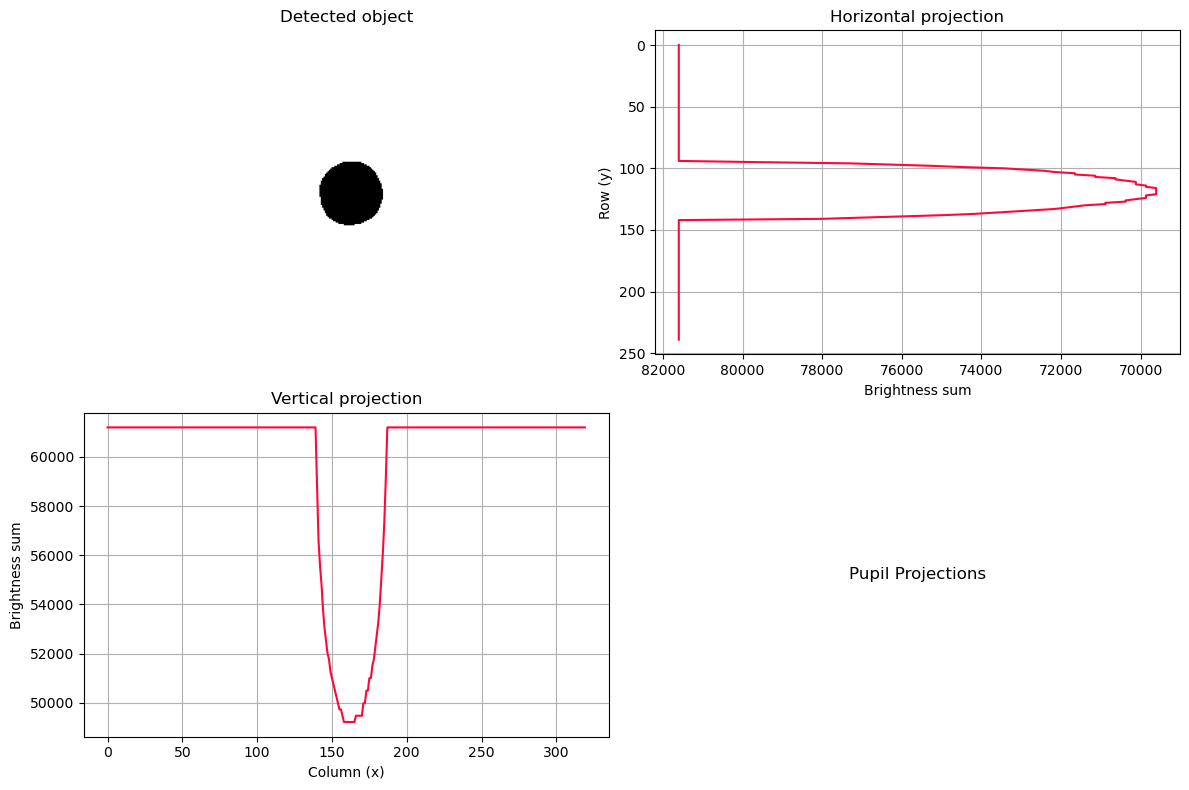

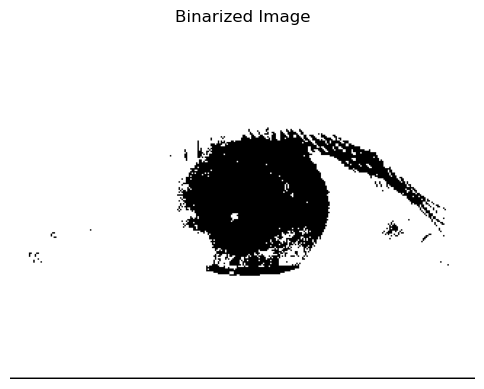

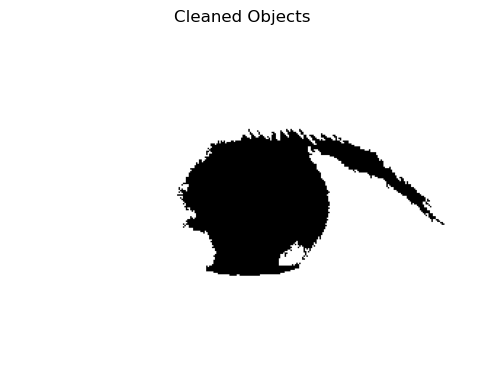

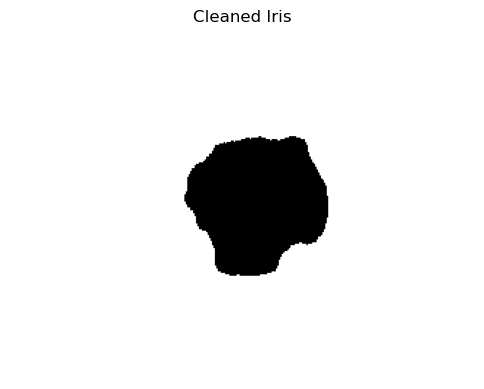

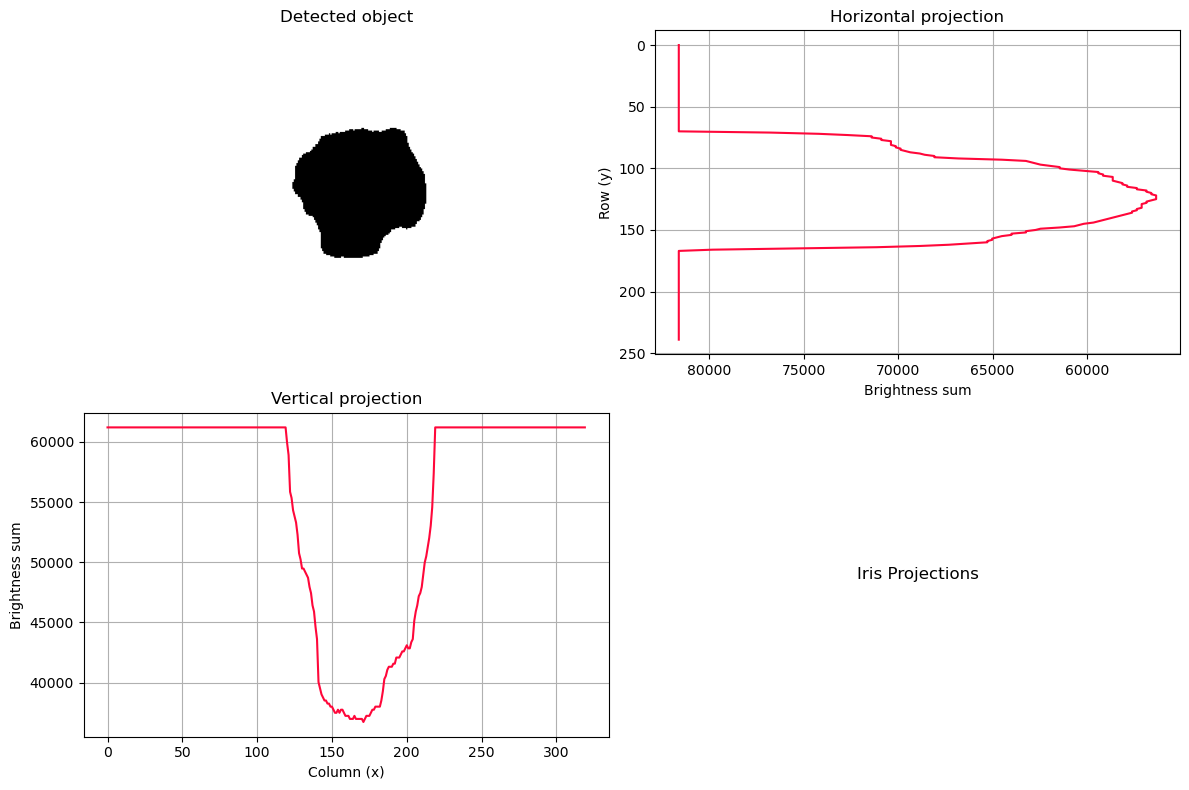

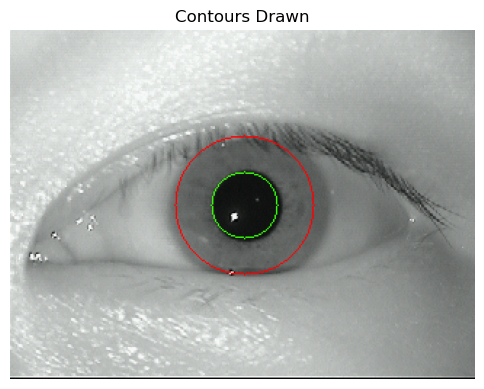

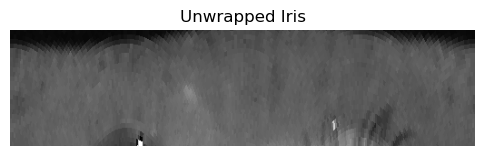

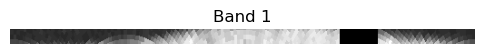

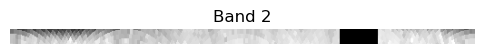

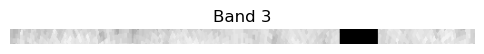

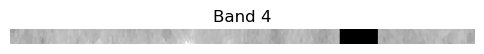

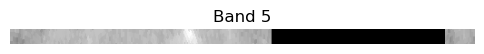

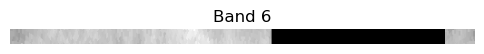

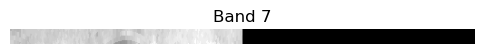

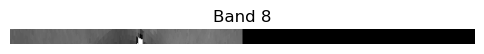

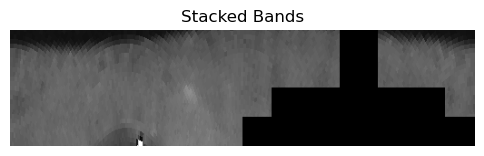

In [194]:
processor3 = IrisSegmenter("./data/MMU-Iris-Database/24/left/ngkokwhyl2.bmp")
processor3.process(Xi=1.623, Xp=5.0)

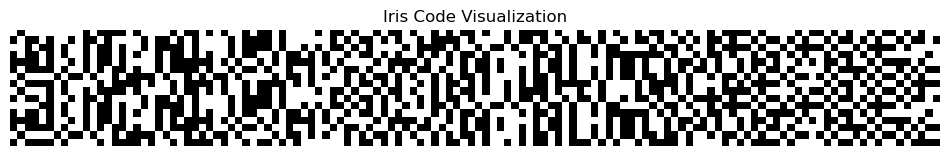

In [195]:
coder3 = IrisRecognizer(processor3.unwrapped_iris)
coder3.process_iris(kernel_size=50, frequency=np.pi)
coder3.visualize_iris_code()

In [196]:
print(coder.hamming_distance(coder2, max_shift=8)) # dla aevar1 i aevar2
print(coder3.hamming_distance(coder, max_shift=8)) # dla aevar1 i ngkokwhyl2
print(coder3.hamming_distance(coder2, max_shift=8)) # dla aevar2 i ngkokwhyl2

0.44902211586070306
0.47822858439388627
0.47126247216953904
